In [318]:

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
%matplotlib inline
import matplotlib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer 


import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')





In [319]:
class DataFrameSelector(BaseEstimator, TransformerMixin):  # class created so we can put in pipeline
    def __init__(self, attribute_names):             # subsets data
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values   #converts df to np array of only values as sklearn works with np

class MyLabelBinarizer(TransformerMixin):  # New LabelBlazer to work with Pipeline
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

Firstly we manually remove outliers by visualzing different features and removing the ones which cause extreme skewness

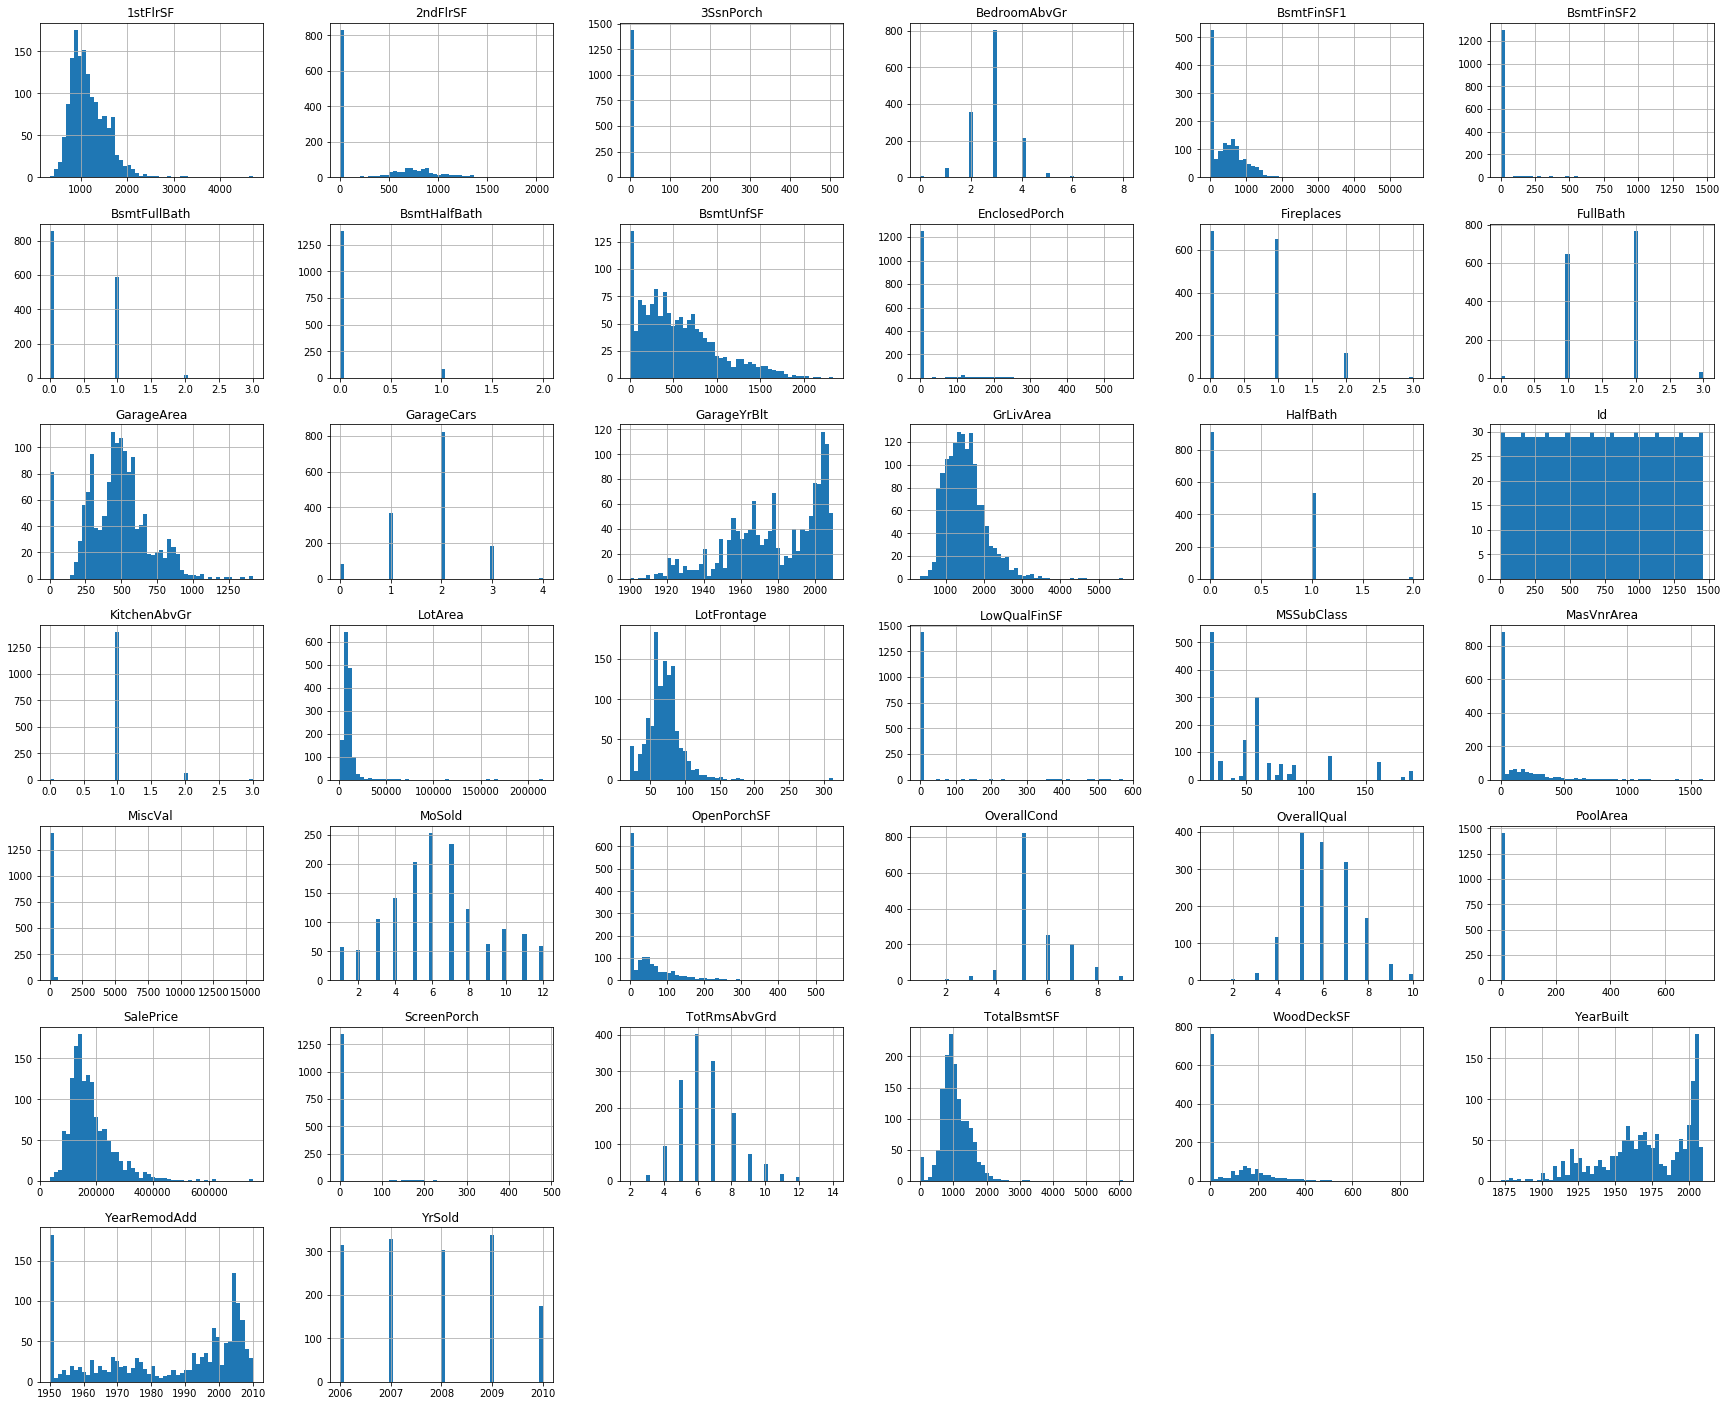

In [320]:
df=pd.read_csv('/Users/admin/Downloads/advancedhousingtrain.csv')
df.hist(bins=50, figsize=(30,25))
plt.show()

In [321]:
df=df[df.SalePrice<450000]
df=df[df.LotArea<100000]
df=df[df.MasVnrArea<800]
df=df[df.TotalBsmtSF<3000]
df=df[df.WoodDeckSF<550]


train=df.copy()

In [322]:
# train.fillna(0)
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

# Some categorical features can be converted to ordered variables

train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}})
                     




Now we bin some numerical features that we assume behave similarly in ranges. This will not force our lr model to add unnecessary value when there is common behavior 

In [323]:
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })

train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
# train=train.fillna(0)


Let us see how SalePrice looks and how its log looks

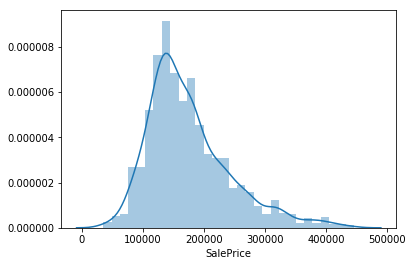

In [324]:
sns.distplot((train['SalePrice']))

In [325]:
train.SalePrice = np.log1p(train.SalePrice)

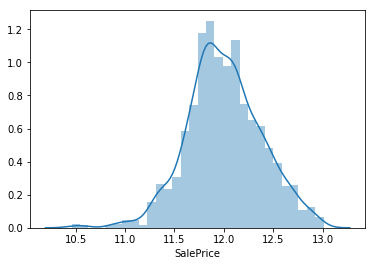

In [326]:
sns.distplot((train['SalePrice']))

We saw that initally this was right skewed but after removing the log transformation we get a much normal histogram.

We want the values to be normally distributed around the mean so that our regression line also centers itself around the mean otherwise if it is more biased towards right/left then the values for the opposite side will be much more skewed.

Lets see how things corelate with our target feature and try and combine some features

In [327]:
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice            1.000000
OverallQual          0.808130
SimplOverallQual     0.708942
GrLivArea            0.696221
GarageCars           0.667759
ExterQual            0.662828
KitchenQual          0.653875
GarageArea           0.640748
BsmtQual             0.637412
SimplExterQual       0.632225
TotalBsmtSF          0.618150
SimplKitchenQual     0.611539
YearBuilt            0.595012
1stFlrSF             0.586319
FullBath             0.581395
SimplBsmtQual        0.577267
YearRemodAdd         0.571887
GarageYrBlt          0.543680
TotRmsAbvGrd         0.504473
HeatingQC            0.476524
Fireplaces           0.471841
Alley                0.453890
MasVnrArea           0.403083
SimplHeatingQC       0.401677
BsmtFinSF1           0.359954
LotFrontage          0.347681
LotArea              0.328621
WoodDeckSF           0.326631
OpenPorchSF          0.319827
PavedDrive           0.310146
                       ...   
BsmtUnfSF            0.207365
GarageQual           0.183694
SimplFirep

We create columns by multiplying very related columns. Linear regression does not take into account multiplicative effects two features have on each other. 

It looks at features independently while in real life one may enchance the effect of the other as in pool area and pool quality.

I dont think it is wise to add similar features as A(x)+B(y) has more flexibility than A(x+y)

In [328]:
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
#  overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
#  overall quality of the exterior
#  overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
#  overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
#  overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
#  overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]



We also add some polynomial features to capture more complex patterns:

In [329]:

# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["KitchenQual-2"] = train["KitchenQual"]**2
train["KitchenQual-3"] = train["KitchenQual"]**3
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

Based on the corelations above I remove some very less corelated features: 

In [330]:
dfdrops=train.copy()
dfdrops.drop(['Fence','Id','LotFrontage','LandContour','LotConfig','LandSlope','RoofMatl','Exterior2nd','OverallCond'
             ,'BsmtFinSF2','LowQualFinSF','BsmtHalfBath','3SsnPorch','PoolArea','MiscVal','MoSold','YrSold'
             ,'PoolQC','MiscFeature','Alley'],axis=1,inplace=True)



Seperate number and categorical columns

In [332]:
target=dfdrops['SalePrice']
df_feat=dfdrops.drop(['SalePrice'],axis=1)




In [333]:
objcol = df_feat.select_dtypes(include='object')
objcol=objcol.columns
intcol = df_feat.select_dtypes(include='int64')
intcol=intcol.columns

floatcol=df_feat.select_dtypes(include='float64')
floatcol=floatcol.columns

# Number Transform

In [334]:
from scipy.stats import skew



Log transform skewed variables + Impute missing values by median

In [336]:
from sklearn.preprocessing import Imputer 
imputer = Imputer(strategy="median") #Imputer using median

numcol=intcol.append(floatcol)
dfdrops2num=df_feat[numcol]

skewness = dfdrops2num.apply(lambda x: skew(x)) #Log transform all skewed varibakes
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
dfdrops2num[skewed_features] = np.log1p(dfdrops2num[skewed_features])


imputer.fit(dfdrops2num)
X=imputer.transform(dfdrops2num)


43 skewed numerical features to log transform


In [337]:
num=pd.DataFrame(X,columns=dfdrops2num.columns) #convert imputer to DataFrame

Standarize all inputs

In [338]:
std=StandardScaler()
std.fit(num)
Y=std.transform(num)

In [339]:
Y=pd.DataFrame(Y,columns=num.columns) #Convert to DataFrame

In [340]:
final_num=Y

# Text
Label Encode all varibales then one hot encode them

In [341]:
dfdrops2obj=df_feat[objcol]
dfdrops2obj.fillna("Nope",inplace=True)
encoder = LabelEncoder()
l=[]
for e in dfdrops2obj:
    convert=dfdrops2obj[e]
    encoded=encoder.fit_transform(convert)
    l.append(encoded)

In [342]:
catdf=pd.DataFrame(l) # Convert back to df
catdf=catdf.T

In [343]:
# OneHotEncoder
from sklearn.preprocessing import OneHotEncoder 
encoder = OneHotEncoder()

housing_cat_1hot = encoder.fit_transform(catdf)
housing_cat_1hot

<1411x149 sparse matrix of type '<type 'numpy.float64'>'
	with 28220 stored elements in Compressed Sparse Row format>

In [344]:
arr=housing_cat_1hot.toarray() # convert sparse matrix to array

In [345]:
df_1hot=pd.DataFrame(arr)#then to df

In [346]:
df_1hot.head()

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [347]:
final = pd.concat([final_num, df_1hot], axis=1, sort=False)


In [348]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression



In [349]:
X_train, X_test, y_train, y_test = train_test_split(final, target, test_size=0.3, random_state=14)



In [350]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score


We see how different values of alpha do for Lasso Resgression

In [351]:
l=[]
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
for alphas in alphas:
    l.append(-cross_val_score(Lasso(alpha=alphas),X_train,y_train,cv=5,scoring="mean_squared_error").mean())
    

In [352]:
print(l)

[0.024305568601483744, 0.04369417649319801, 0.13672759872392068, 0.14112990912544027, 0.14112990912544027, 0.14112990912544027, 0.14112990912544027, 0.14112990912544027, 0.14112990912544027, 0.14112990912544027, 0.14112990912544027]


Text(0,0.5,u'rmse')

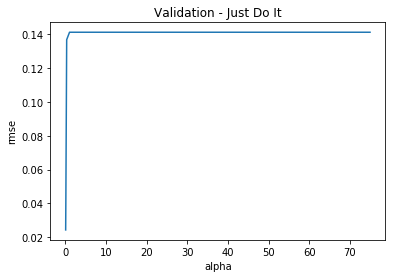

In [353]:
# def rmse_cv(model):
#     rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
#     return(rmse)
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

# cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(np.array(l), index = np.array(alphas))
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

As shown as close we are to 0 the better:

however slight increases will remove a bunch of parameters and help curve overfitting compared to training loss accuracy

In [354]:
ridgereg = Lasso(alpha=0.0000000001)
ridgereg.fit(X_train,y_train)
housing_predictions = ridgereg.predict(X_test)

lin_mse = mean_squared_error(np.exp(housing_predictions), np.exp(y_test))
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

ridgereg = Lasso(alpha=0.001)
ridgereg.fit(X_train,y_train)
housing_predictions = ridgereg.predict(X_test)

lin_mse = mean_squared_error(np.exp(housing_predictions), np.exp(y_test))
lin_rmse = np.sqrt(lin_mse)
lin_rmse

21712.21157056541


21790.16832788675

In [355]:
We see how different values of alpha do for Lasso Resgression

SyntaxError: invalid syntax (<ipython-input-355-798f8acd230c>, line 1)

In [ ]:
ridgereg = Ridge(alpha=0.003)
l=[]
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
for alphas in alphas:
    l.append(-cross_val_score(Ridge(alpha=alphas),X_train,y_train,cv=5,scoring="mean_squared_error").mean())
    

In [ ]:
# def rmse_cv(model):
#     rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
#     return(rmse)
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

# cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(np.array(l), index = np.array(alphas))
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [356]:
ridgereg = Ridge(alpha=10)
ridgereg.fit(X_train,y_train)
housing_predictions = ridgereg.predict(X_test)

lin_mse = mean_squared_error(np.exp(housing_predictions), np.exp(y_test))
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

ridgereg = Ridge(alpha=7)
ridgereg.fit(X_train,y_train)
housing_predictions = ridgereg.predict(X_test)
housing_predictions=np.array(housing_predictions)
# np.nan_to_num(housing_predictions,0)
lin_mse = mean_squared_error(np.exp(housing_predictions), np.exp(y_test))
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

21273.079544128195
21289.12779358783


In [357]:
Close to around 7 works good

SyntaxError: invalid syntax (<ipython-input-357-77193179fed5>, line 1)

In [358]:
Visualize which variables were given importance:

SyntaxError: invalid syntax (<ipython-input-358-fd87fab28cc9>, line 1)

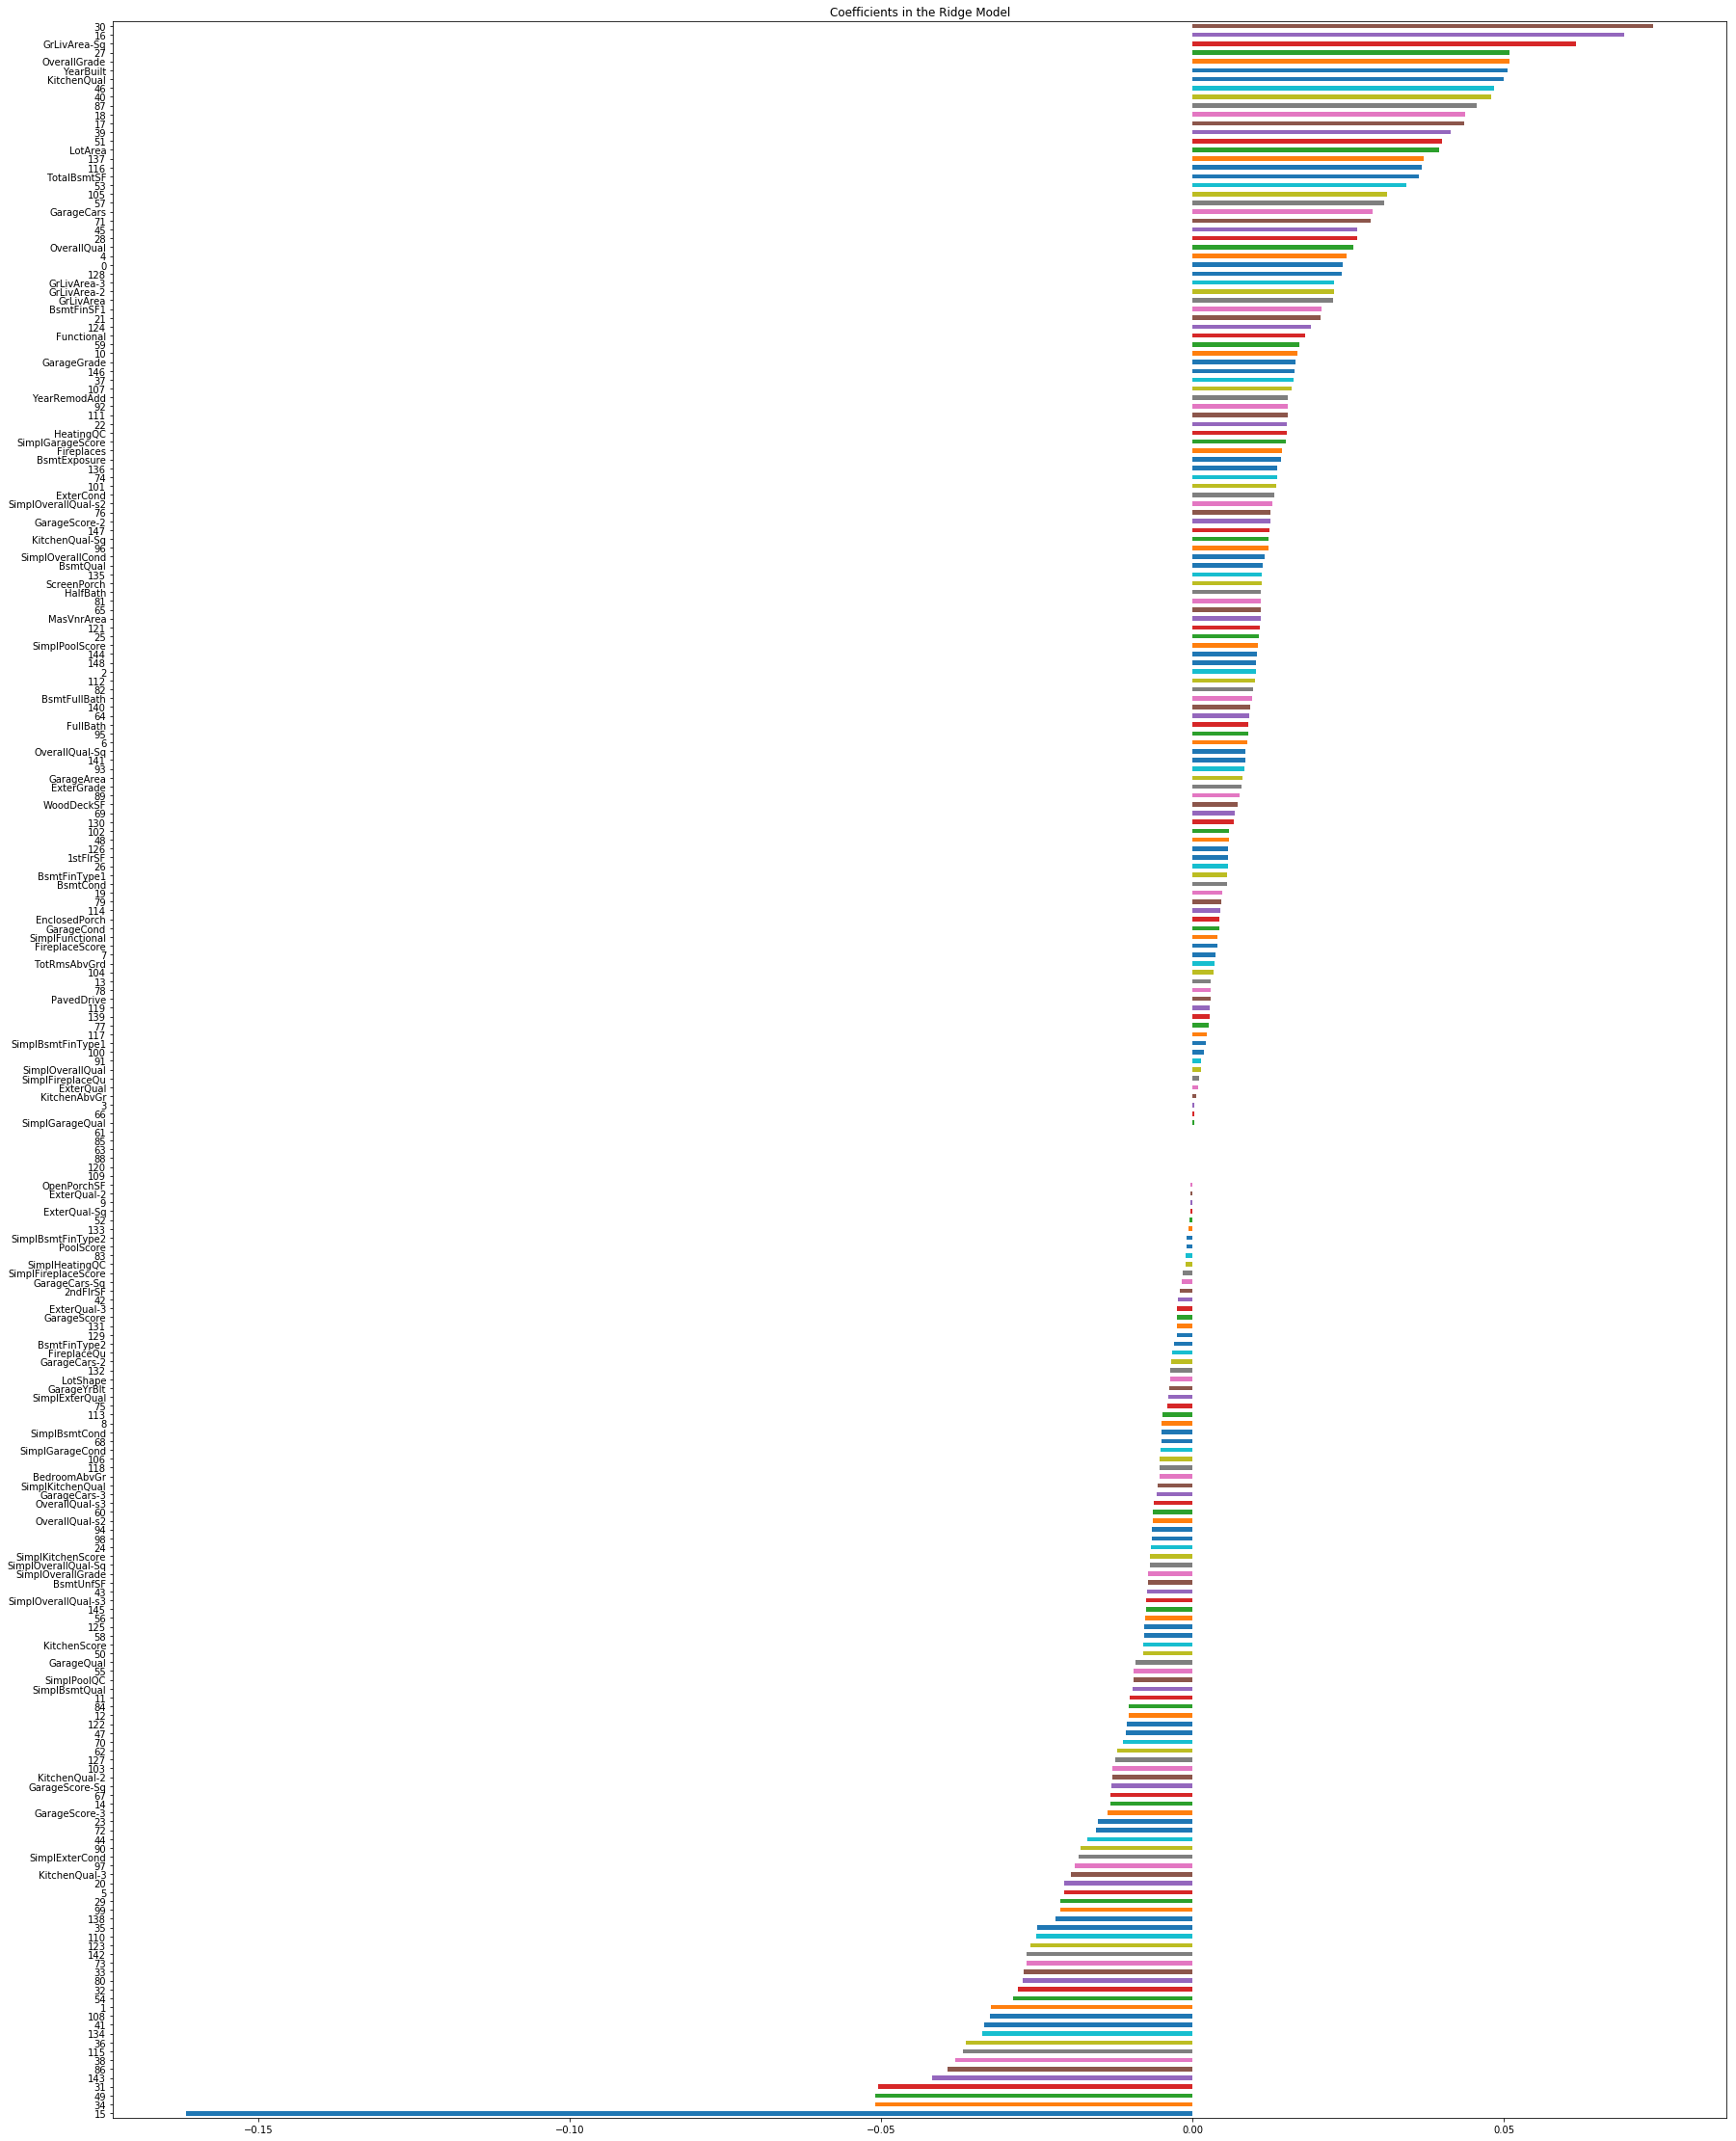

In [359]:
s=pd.Series(ridgereg.coef_,index=X_train.columns)
s=s.sort_values(axis=0)
# print(s)
plt.figure(figsize=(30,40))
s.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()